In [ ]:
!pip install tensorflow==2.15.0
!pip install tensorflow-addons

In [ ]:
import os
import tensorflow_addons as tfa
import random
import time
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from math import ceil
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow_addons.metrics import RSquare
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Lasso

In [ ]:
def cleandata(data):
    for col in data.columns:
        data = data[data[col] != -9999.0]
        data = data[data[col] != -9999.99]
    data = data[data['wv (m/s)'] >= 0]
    return data

def findnanrows(df):
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    return rows_with_NaN

def interpolatedata(df):
    filldf = df.groupby(pd.Grouper(freq='10T')).mean()
    dfnan = findnanrows(filldf)
    print("==> %s rows have been filled <==" %len(dfnan))
    filldf = filldf.interpolate().round(2)
    return filldf

In [ ]:
class VizData():
    def __init__(self, data):
        self.data = data

    def plotfeatures(self, mode, title):
        features = self.data.columns.tolist()
        plot_features = self.data.groupby(pd.Grouper(freq=str(mode)+'T')).mean()
        plot_features = plot_features[features]
        plot_features.index = plot_features.index
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), facecolor="w", edgecolor="k")
        for i, feature in enumerate(features):
            axes[i // ncols, i % ncols].plot(plot_features[feature])
            axes[i // ncols, i % ncols].set_title(f'{feature} - {title}')
        plt.tight_layout()
        plt.show()

    def plothist2d(self, feature):
        f = self.data.columns.tolist()
        features = [x for x in f if x != feature]
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
        for i, feature_x in enumerate(features):
            if i == nrows * ncols - 2:
                ax = plt.subplot(nrows,1,ncols)
                counts, xedges, yedges, img = plt.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                print("/n")
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')
                plt.colorbar(img, ax=ax)
                plt.gca()
            else:
                ax = plt.subplot(nrows,ncols,i+1)
                counts, xedges, yedges, img = ax.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                print("/n")
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')
                plt.colorbar(img, ax=ax)
                plt.gca()
        plt.show()

    def plotbox(self, mode):
        plot_features = self.data.groupby(pd.Grouper(freq=str(60)+'T')).mean().copy()
        plot_features[mode] = [eval('x.%s'%mode) for x in plot_features.index]
        plot_features.boxplot('wv (m/s)', by=mode, figsize=(12, 8), grid=False)
        plt.show()

In [ ]:

weather = pd.read_csv("/content/mpi_roof.csv", encoding='ISO-8859-1', parse_dates=["Date Time"], index_col="Date Time", dayfirst=True)

weather.index = pd.to_datetime(weather.index, dayfirst=True)
# weather.index.name = 'Date Time'
weather = weather[[x for x in weather.columns if x != 'CO2 (ppm)']]

print("Size before cleaning data:", weather.shape)
weather = cleandata(data=weather)
print("Size after cleaning data:", weather.shape)

print("Size before filling data:", weather.shape)
#weather = filldata(weather)
weather = interpolatedata(weather)
print("Size after filling data:", weather.shape)
weather.head()
weather.columns



Size before cleaning data: (42241, 20)
Size after cleaning data: (42218, 20)
Size before filling data: (42218, 20)
==> 23 rows have been filled <==
Size after filling data: (42241, 20)


<ipython-input-9-f02d2b089015>:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  filldf = df.groupby(pd.Grouper(freq='10T')).mean()


Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)'],
      dtype='object')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Inspect column names
print(weather.columns.tolist())

# Update usecols to include only the columns available in the dataset
usecols = [
    col for col in [
        'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
        'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)'
    ] if col in weather.columns
]

# Filter the dataframe to include only the selected columns
weather = weather[usecols]
print(f"Filtered DataFrame Columns: {weather.columns.tolist()}")



['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)', 'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)']
Filtered DataFrame Columns: ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)', 'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)']


<ipython-input-10-2db895e4a0e2>:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  plot_features = self.data.groupby(pd.Grouper(freq=str(mode)+'T')).mean()


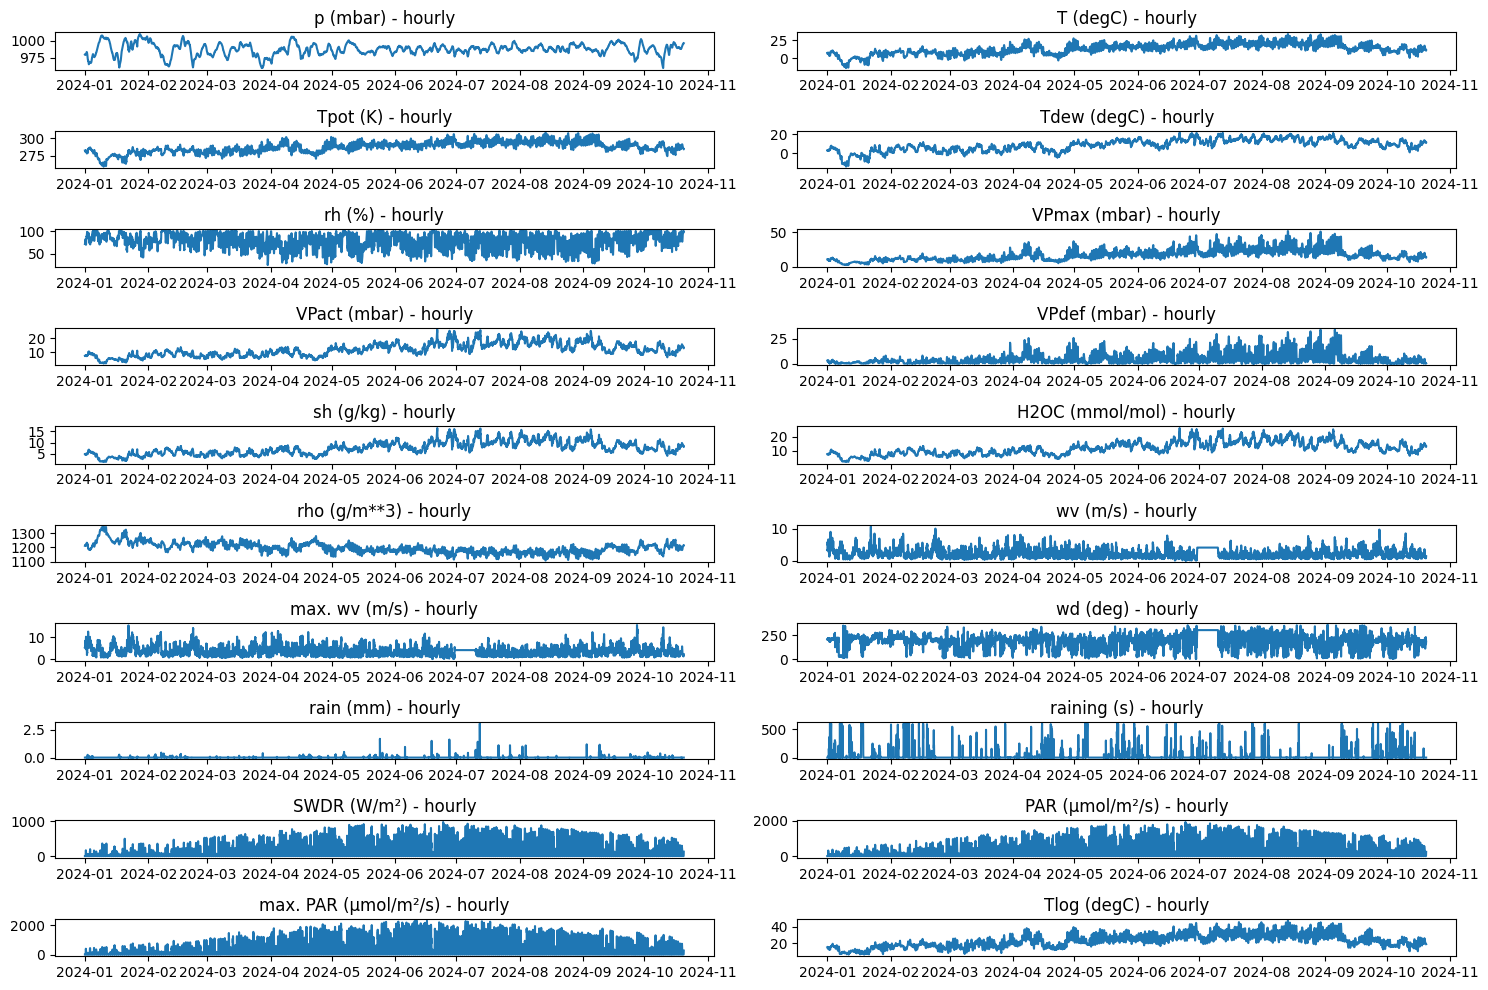

<ipython-input-10-2db895e4a0e2>:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  plot_features = self.data.groupby(pd.Grouper(freq=str(mode)+'T')).mean()


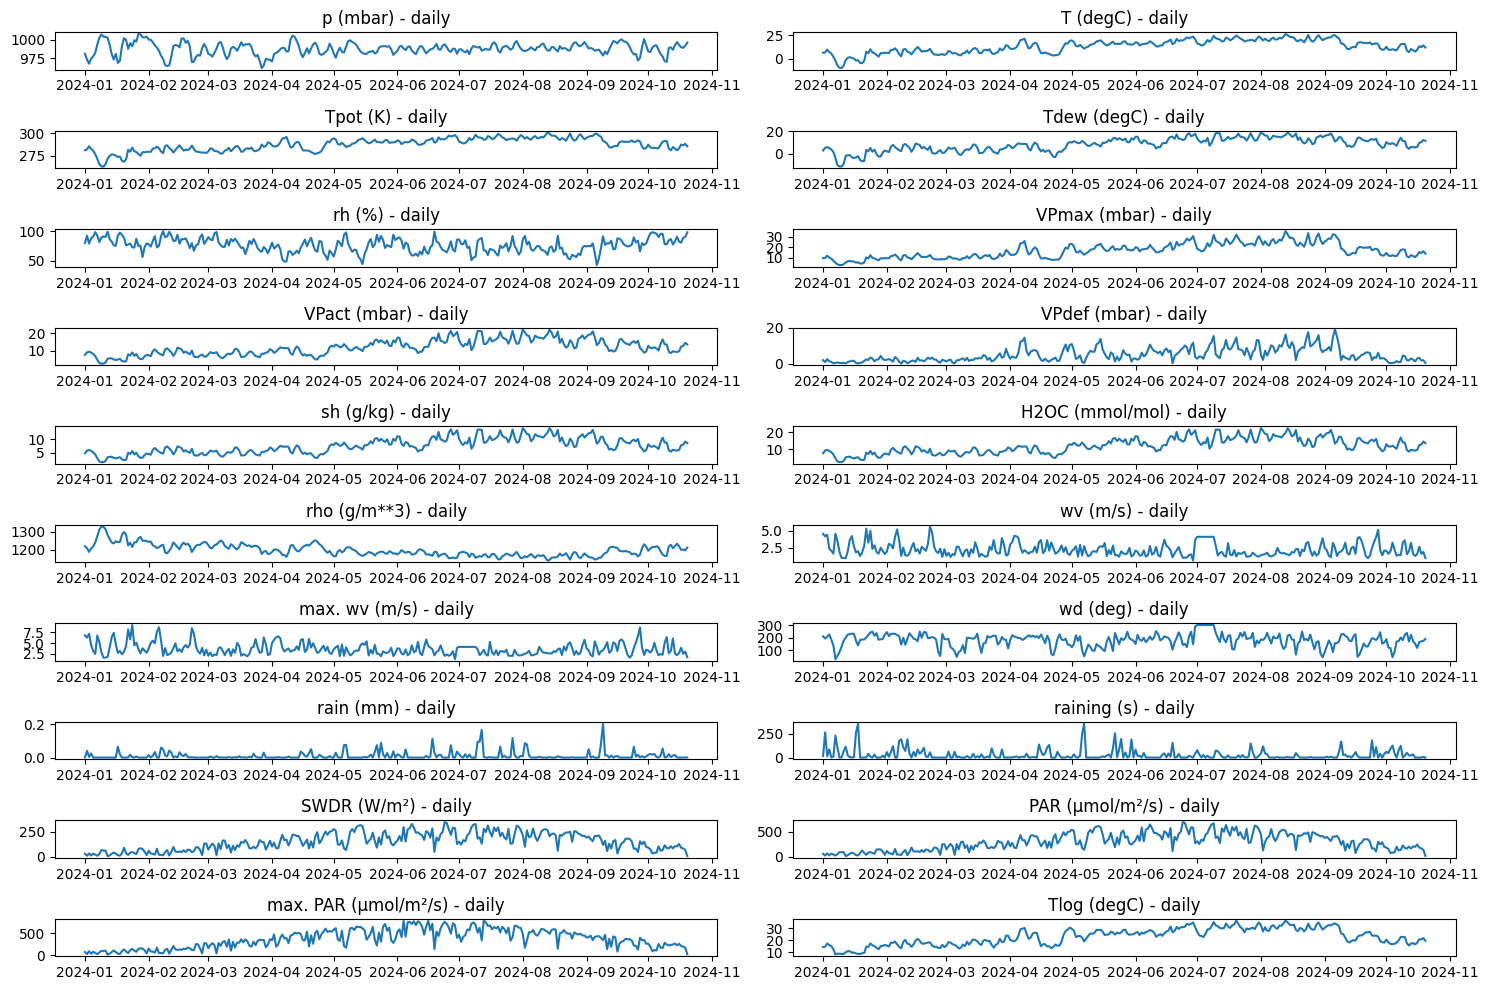

/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n
/n


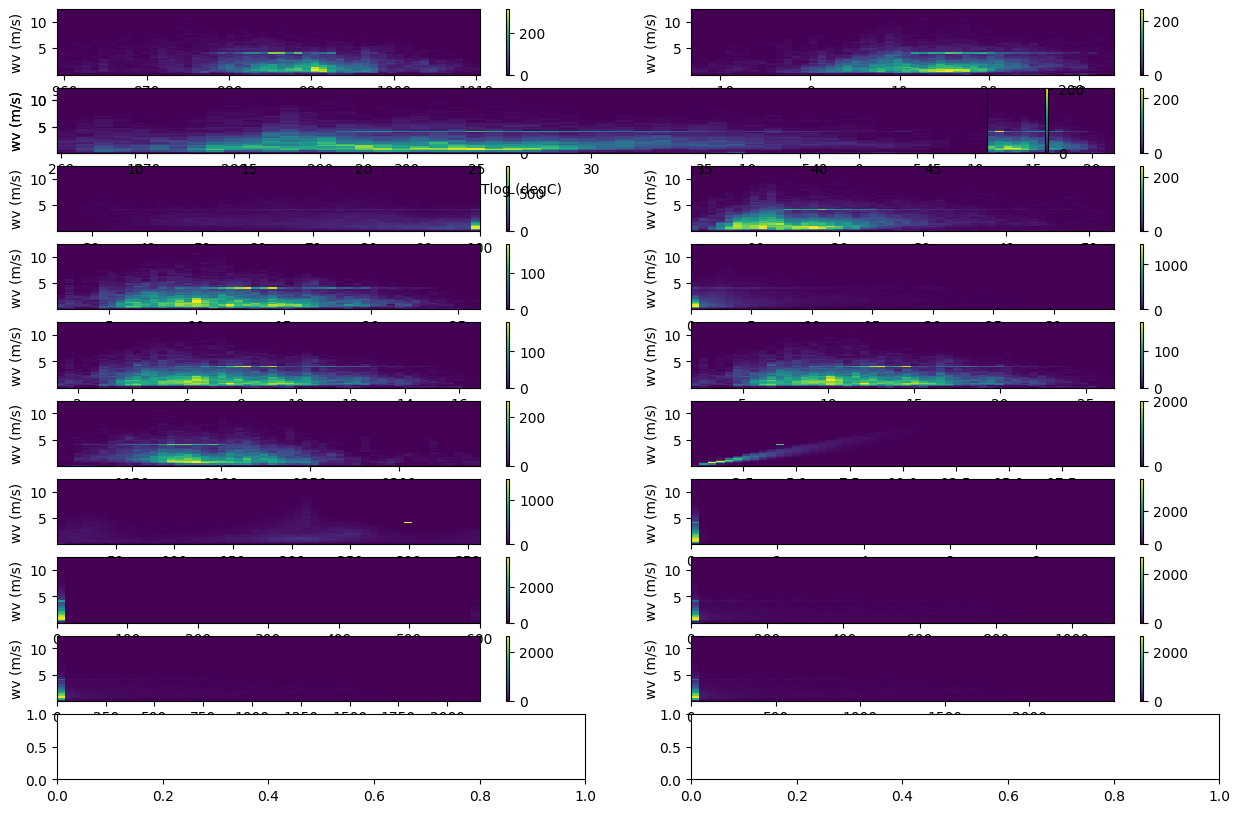

<ipython-input-10-2db895e4a0e2>:47: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  plot_features = self.data.groupby(pd.Grouper(freq=str(60)+'T')).mean().copy()


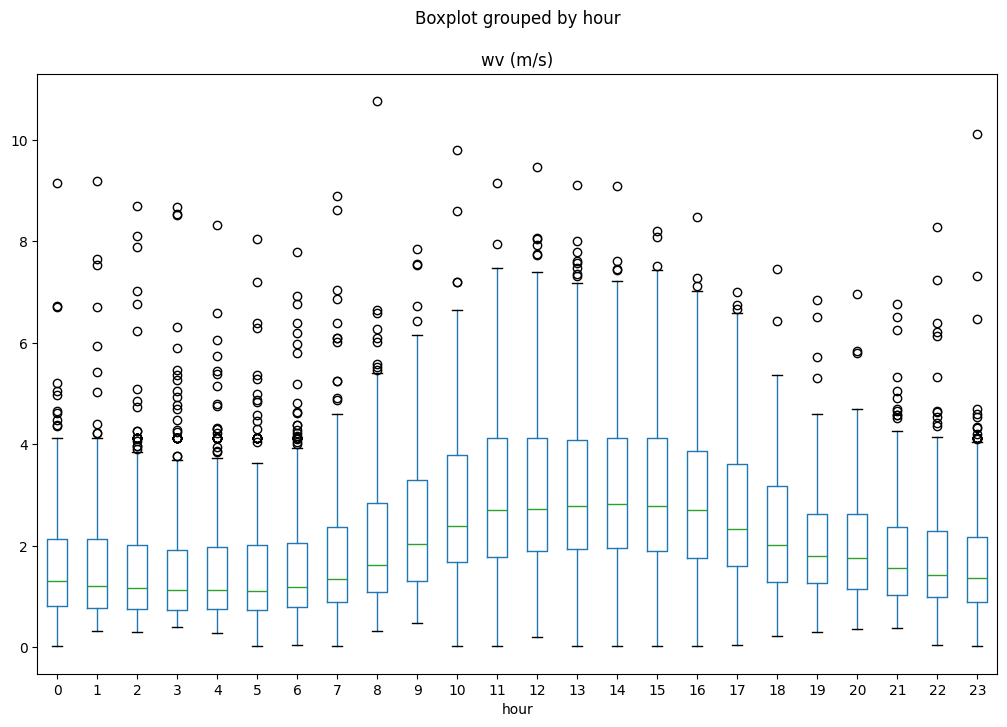

<ipython-input-10-2db895e4a0e2>:47: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  plot_features = self.data.groupby(pd.Grouper(freq=str(60)+'T')).mean().copy()


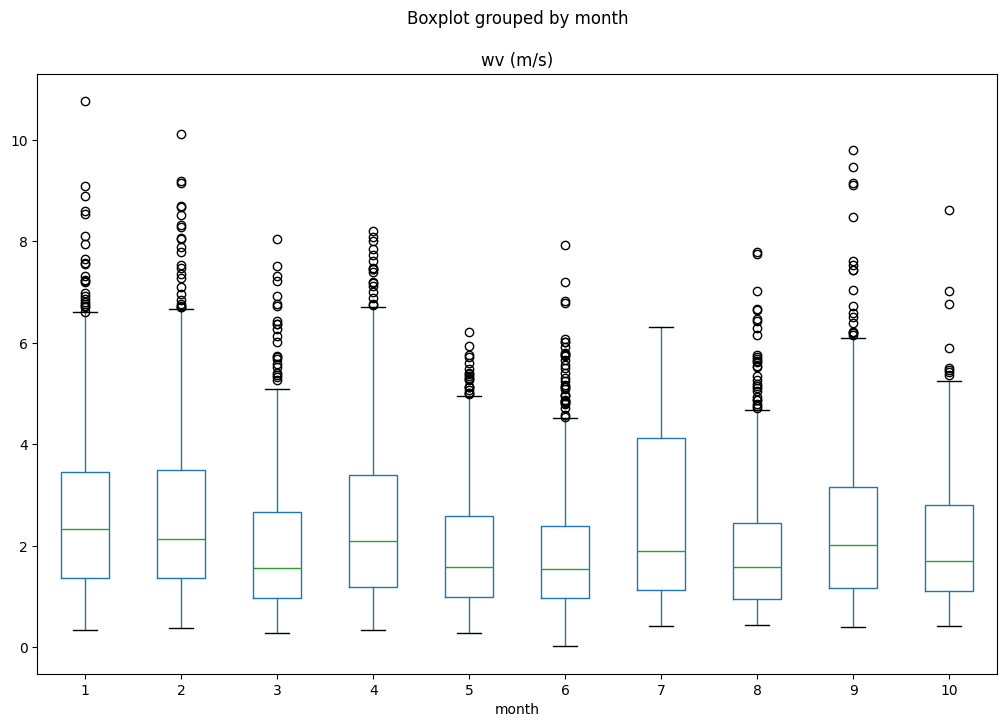

In [ ]:
vd = VizData(data=weather)
vd.plotfeatures(mode=60, title="hourly")
vd.plotfeatures(mode=60*24, title="daily")
vd.plothist2d(feature="wv (m/s)")
vd.plotbox(mode="hour")
vd.plotbox(mode="month")

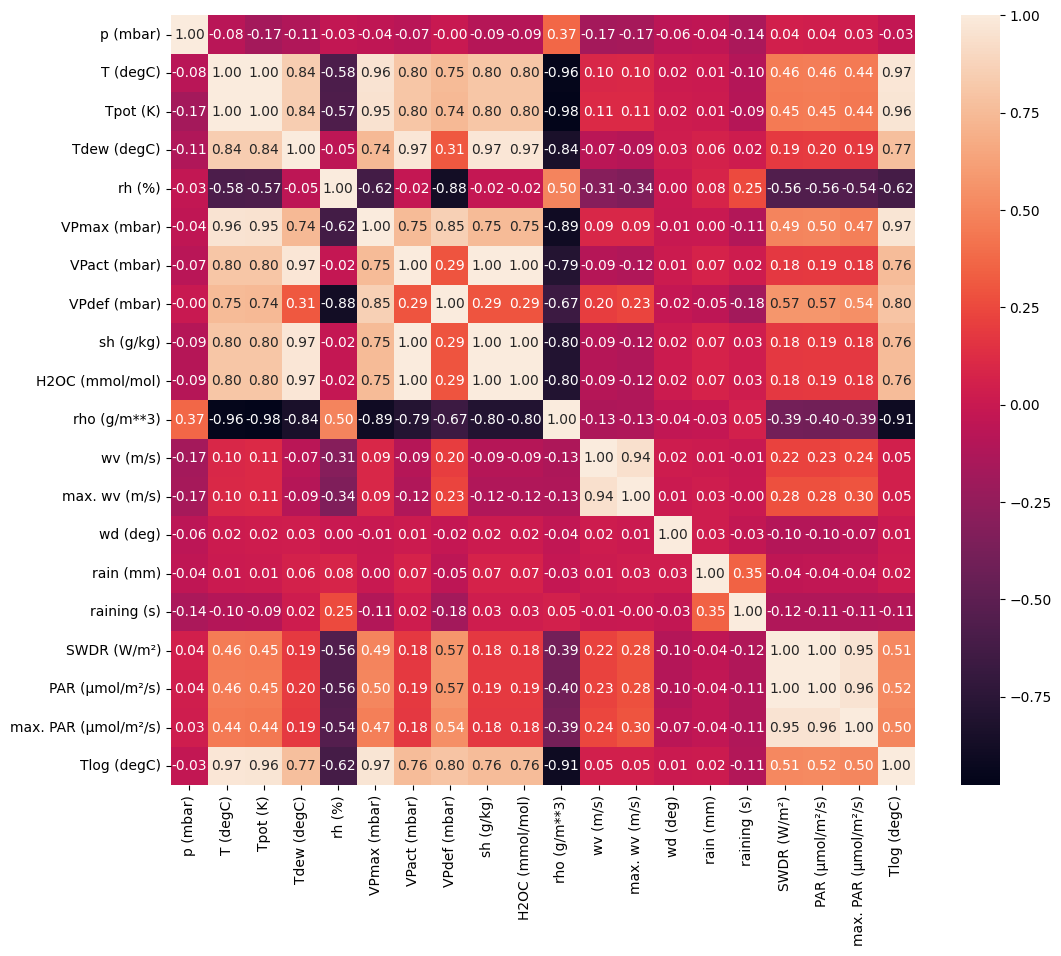

In [ ]:
corr_matrix = weather.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [ ]:
class DataPreprocessing():
    def __init__(self, data, sampling_window,target_column, **kwargs):
        # self.data = data
        # self.sampling_window = sampling_window
        # self.trainsize = kwargs.get('trainsize', 0.7)
        # self.valsize = kwargs.get('valsize', 0.2)
          self.data = data
          self.sampling_window = sampling_window
          self.target_column = target_column
          self.trainsize = kwargs.get('trainsize', 0.7)
          self.valsize = kwargs.get('valsize', 0.2)
    def wrap_feature_selection(self, estimator, n_features):
        """
        Perform Recursive Feature Elimination (RFE) to select top features.
        Args:
            estimator: The model to use for feature selection (e.g., LinearRegression).
            n_features: Number of features to select.
        Returns:
            Selected feature names.
        """
        feature_names = [col for col in self.data.columns if col != self.target_column]
        X = self.data[feature_names].values
        y = self.data[self.target_column].values  # Assuming the first column is the target

        # Use RFE for feature selection
        rfe = RFE(estimator=estimator, n_features_to_select=n_features)
        rfe.fit(X, y)
        feature_ranking = sorted(zip(feature_names, rfe.ranking_), key=lambda x: x[1])
        print("Feature rankings:")
        for feature, rank in feature_ranking:
          print(f"{feature}: Rank {rank}")

        # Get selected features
        selected_features = [feature for feature, selected in zip(feature_names, rfe.support_) if selected]
        print(f"Selected Features: {selected_features}")
        self.selected_features = selected_features
        return selected_features


    def datasplit(self, **kwargs):
        self.addcyclics = kwargs.get('addcyclics', False)
        self.normalize = kwargs.get('normalize', None)
        self.features = kwargs.get('features', None)
        use_wrap = kwargs.get('use_wrap', False)
        if use_wrap:
            estimator = kwargs.get('estimator', LinearRegression())
            n_features = kwargs.get('n_features', 5)
            print("Using wrap feature selection.")
            self.selected_features = self.wrap_feature_selection(estimator, n_features)
            # Include the target variable in the features list
            self.features =  self.selected_features
        else:
             print("Using provided features.")
        self.resample_data = self.data.resample(str(self.sampling_window)+'T').mean()

        if self.resample_data.isna().sum().sum() > 0:
            raise Exception(f"Oops! there are some NaN values in resampled data.")

        if self.features is not None:
            print(f"Using features: {self.features}")
            self.resample_data =self.resample_data[self.features + [self.target_column]]
        if self.addcyclics:
            self.resample_data = self.__class__.cyclical(self.resample_data)
            self.features = self.resample_data.columns

        self.train_df = self.resample_data[0:int(len(self.resample_data)*self.trainsize)]
        self.val_df = self.resample_data[int(len(self.resample_data)*self.trainsize):int(len(self.resample_data)*(self.trainsize+self.valsize))]
        self.test_df = self.resample_data[int(len(self.resample_data)*(self.trainsize+self.valsize)):]

        if self.normalize is not None:
            if self.normalize == 'MinMaxScaler':
                self.scaler = MinMaxScaler(feature_range=(0, 1))
            elif self.normalize == 'StandardScaler':
                self.scaler = StandardScaler()
            # normalizing input features
            self.train_df = pd.DataFrame(self.scaler.fit_transform(self.train_df), columns=self.train_df.columns, index=self.train_df.index)
            self.val_df = pd.DataFrame(self.scaler.transform(self.val_df), columns=self.val_df.columns, index=self.val_df.index)
            self.test_df = pd.DataFrame(self.scaler.transform(self.test_df), columns=self.test_df.columns, index=self.test_df.index)
        print("Columns in train_df after normalization:")
        print(self.train_df.columns.tolist())
        return self.train_df, self.val_df, self.test_df

    @staticmethod
    def cyclical(data):
        data = data.copy()
        # Extracting the hour of day
        data["hour"] = [x.hour for x in data.index]
        # Creating the cyclical daily feature
        data["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in data["hour"]]
        data["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in data["hour"]]
        # Extracting the timestamp from the datetime object
        data["timestamp"] = [x.timestamp() for x in data.index]
        # Seconds in day
        s = 24 * 60 * 60
        # Seconds in year
        year = (365.25) * s
        data["month_cos"] = [np.cos((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data["month_sin"] = [np.sin((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data = data.drop(['hour', 'timestamp'], axis=1)
        return data

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 batch_size, sequence_stride,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift + label_width

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.input_width + self.shift
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Offset: {self.shift}',
            f'Label column name(s): {self.label_columns}',
            f'Features: {self.train_df.columns.tolist()}',
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data, sequence_stride):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=sequence_stride,
            shuffle=False,
            batch_size=self.batch_size,
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df, self.sequence_stride)
    @property
    def val(self):
        return self.make_dataset(self.val_df, self.sequence_stride)
    @property
    def test(self):
        return self.make_dataset(self.test_df, self.sequence_stride)

    @property
    def flattrain(self):
        return self.make_dataset(self.train_df, self.label_width)
    @property
    def flatval(self):
        return self.make_dataset(self.val_df, self.label_width)
    @property
    def flattest(self):
        return self.make_dataset(self.test_df, self.label_width)

    def randomplots(self, mc=None, max_subplots=3, **kwargs):
        plot_col = kwargs.get('plot_col', self.label_columns[0])

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))

        plot_col_index = self.column_indices[plot_col]
        indexes = random.sample(range(len(real_x)), max_subplots)

        if mc is not None:
            reshape_real_x = mc.reshape(real_x)
            max_subplots = max_subplots + 1

        plt.figure(figsize=(12, 8))
        for n in range(max_subplots):
            plt.subplot(max_subplots, 1, n+1)
            if n == max_subplots - 1 and mc is not None:
                plt.plot(real_y[:, :, label_col_index].reshape(-1, 1))
                plt.plot(predictions.reshape(-1, 1))

            else:
                plt.plot(self.input_indices, real_x[indexes[n], :, plot_col_index],
                         label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                    label_col_index = plot_col_index

                if label_col_index is None:
                    continue

                plt.scatter(self.label_indices, real_y[indexes[n], :, label_col_index],
                            marker='p', edgecolors='k', label='Labels',
                            c='#2ca02c', s=64)
                if mc is not None:
                    predictions = mc.model.predict(reshape_real_x)
                    plt.scatter(self.label_indices, predictions[indexes[n], :],
                                marker='*', edgecolors='k', label='Predictions',
                                c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
                plt.title(f'{plot_col} [scaled]')
        plt.xlabel('Timesteps')

    def plotforecast(self, mc, title, **kwargs):
        withinputs = kwargs.get('withinputs', False)
        windows = kwargs.get('windows', None)
        labels = ["Actual values", "Predicted values"]

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))
        pred_y = mc.model.predict(mc.reshape(real_x))

        real_y = real_y.reshape(-1, 1)
        pred_y = pred_y.reshape(-1, 1)

        plt.figure(figsize=(15,5))
        if withinputs:
            plt.plot(self.test_df[self.label_columns].values[:self.input_width+len(pred_y[:windows])], label=labels[0])
            plt.plot(np.arange(self.input_width, self.input_width+len(pred_y[:windows])), pred_y[:windows], label=labels[1])
        else:
            plt.plot(real_y[:windows], label=labels[0])
            plt.plot(pred_y[:windows], label=labels[1])
        plt.title(f'{title}: {self.input_width} previous timesteps-based {self.label_width} future timesteps forecasting')
        plt.xlabel("Test dataset points")
        plt.legend(frameon=False)
        plt.show()

In [ ]:
class ModelingClass():
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1):
        self.mapdataset = mapdataset
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.loss = loss
        self.metrics = metrics
        self.label_feature_number = list(map(lambda x: x[1].numpy(), mapdataset.train.take(1)))[0].shape[2]

    def reshape(self, data):
        return data

    # build the model
    def modelbuild(self):
        # define model
        model = None
        return model

    def traincallback(self):
        # simple early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=self.patience, verbose=1)
        return early_stopping

    # train the model
    def train(self):
        # Building the model
        self.model = self.modelbuild()
        # Initiating the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Instantiate an optimizer before passing it to model.compile() or pass it by its string identifier.
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        # fit network
        if (self.mapdataset.val is not None):
            self.history = self.model.fit(
                self.mapdataset.train,
                validation_data=self.mapdataset.val,
                epochs=self.epochs,
                verbose=self.verbose,
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        else:
            self.history = self.model.fit(
                self.mapdataset.train,
                epochs=self.epochs,
                verbose=self.verbose,
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        return self.history

    # def computemetrics(self, mapdata):
    #     real_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdata)))
    #     real_y = real_y.reshape(real_y.shape[0], real_y.shape[1])
    #     pred_y = self.model.predict(mapdata)
    #     pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1])

    #     RMSE = mean_squared_error(real_y, pred_y, squared=False)
    #     MSE = mean_squared_error(real_y, pred_y)
    #     MAE = mean_absolute_error(real_y, pred_y)
    #     MAPE = 100*mean_absolute_percentage_error(real_y, pred_y)
    #     R2 = r2_score(real_y, pred_y)
    #     # calculate the metric score for each timestep
    #     rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
    #     mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
    #     mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
    #     mape_scores = 100*mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
    #     r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')
    #     print('rmse: %.4f [%s]' %(RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
    #     print('mse : %.4f [%s]' %(MSE, ', '.join(['%.4f' % s for s in mse_scores])))
    #     print('mae : %.4f [%s]' %(MAE, ', '.join(['%.4f' % s for s in mae_scores])))
    #     print('mape: %.4f [%s]' %(MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
    #     print('r2  : %.4f [%s]' %(R2, ', '.join(['%.4f' % s for s in r2_scores])))
    def computemetrics(self, mapdata):
          real_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdata)), axis=0)
          pred_y = self.model.predict(mapdata)
          if real_y.shape[0] != pred_y.shape[0]:
            raise ValueError(f"Mismatch between real_y ({real_y.shape[0]}) and pred_y ({pred_y.shape[0]}).")
          real_y = real_y.reshape(-1, real_y.shape[-1])
          pred_y = pred_y.reshape(-1, pred_y.shape[-1])
          RMSE = mean_squared_error(real_y, pred_y, squared=False)
          MSE = mean_squared_error(real_y, pred_y)
          MAE = mean_absolute_error(real_y, pred_y)
          MAPE = 100 * mean_absolute_percentage_error(real_y, pred_y)
          R2 = r2_score(real_y, pred_y)  # Calculate R-Square

    # Calculate metrics for each timestep
          rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
          mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
          mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
          mape_scores = 100 * mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
          r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')

          print('rmse: %.4f [%s]' % (RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
          print('mse : %.4f [%s]' % (MSE, ', '.join(['%.4f' % s for s in mse_scores])))
          print('mae : %.4f [%s]' % (MAE, ', '.join(['%.4f' % s for s in mae_scores])))
          print('mape: %.4f [%s]' % (MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
          print('r2  : %.4f [%s]' % (R2, ', '.join(['%.4f' % s for s in r2_scores])))


    @property
    def trainmetrics(self):
        return self.computemetrics(self.mapdataset.train)
    @property
    def valmetrics(self):
        return self.computemetrics(self.mapdataset.val)
    @property
    def testmetrics(self):
        return self.computemetrics(self.mapdataset.test)

    def lossplot(self, **kwargs):
        if len(self.model.metrics_names) <= 2:
            l, c = 1, 2
        else:
            l, c = (len(self.model.metrics_names)//2)+1, 2
        title = kwargs.get('title', "")
        epochs = range(len(self.history.history[self.model.metrics_names[0]]))
        plt.figure(figsize=(15,3.5*l))
        for i in range(len(self.model.metrics_names)):
            plt.subplot(l,c,i+1)
            if self.model.metrics_names[i] == "loss":
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.loss[0]+'*')
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.loss[0]+'*')
                plt.xlabel("Epochs")
                plt.ylabel(self.loss[0]+'*')
                plt.legend(frameon=False)
            else:
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.model.metrics_names[i])
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.model.metrics_names[i])
                plt.xlabel("Epochs")
                plt.ylabel(self.model.metrics_names[i])
                plt.legend(frameon=False)
        plt.suptitle("Training and validation losses: {}".format(title))
        plt.subplots_adjust(hspace=0.4)
        plt.show()

    def modelevaluate(self, train_performance, val_performance, test_performance):
        for x in ["train", "val", "test"]:
            print("\nModel evaluation on %s dataset:\n"%x)
            eval("%s_performance"%x)[self.__class__.__name__] = self.model.evaluate(eval("self.mapdataset.%s"%x))
            print(list(map(lambda x: round(x, 4), eval("%s_performance"%x)[self.__class__.__name__])))
        return train_performance, val_performance, test_performance

In [ ]:
sampling_window = 60
addcyclics = False
normalize = True
#normalize_type = "StandardScaler"
normalize_type = "MinMaxScaler"

n_input, n_output = 48, 7 #48, 7
sequence_stride = 1
epochs, batch_size, learning_rate, patience = 200, 2**7, 0.001, 10 #150, 2**7, 0.001, 10
loss = 'mse'  # Define the loss function
metrics = ['mae', 'mape', RSquare(name='r2')]  # Define metrics
usecols = [
    col for col in [
        'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
        'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)'
    ] if col in weather.columns
]

features = usecols

train_performance = {}
val_performance = {}
test_performance = {}

In [ ]:
def run(data, modelingclassname, title, train_performance, val_performance, test_performance):
   start = time.time()
   dp = DataPreprocessing(data=weather, sampling_window=sampling_window, target_column='wv (m/s)')
   train_df, val_df, test_df = dp.datasplit(
    addcyclics=addcyclics,
    normalize=normalize_type,
    use_wrap=True,
    estimator =  LinearRegression(),
    n_features=2
)
   print(f"\nFeatures used in wrap method: {dp.selected_features}\n")
    # Update label_columns for PCA
   label_columns = [dp.target_column]

    # Window generation
   mw = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=n_input,
        label_width=n_output,
        shift=0,
        label_columns=label_columns,  # Use updated label_columns
        batch_size=batch_size,
        sequence_stride=sequence_stride,
    )

   mc = modelingclassname(
        mapdataset=mw,
        epochs=epochs,
        patience=patience,
        learning_rate=learning_rate,
        loss=loss,
        metrics=metrics)

   history = mc.train()

   IPython.display.clear_output()

   print(mw)

   for example_inputs, example_labels in mw.train.take(1):
    #for example_inputs, example_labels in mw.train:

     print(f'\nInput shape (batch size, timesteps, features): {example_inputs.shape}')

     print(f'Label shape (batch size, timesteps, features): {example_labels.shape}\n')
     print(f'Features used in input: {dp.features}')
     print(f'Target variable: {dp.target_column}')
   display(tf.keras.utils.plot_model(mc.model, mc.__class__.__name__+"_model_with_shape_info.png", show_shapes=True, show_layer_names=True))

   train_performance, val_performance, test_performance = mc.modelevaluate(train_performance, val_performance, test_performance)

   print("\nModeling metrics on train data set:\n")
   mc.trainmetrics
   print("\nModeling metrics on validation data set:\n")
   mc.valmetrics
   print("\nModeling metrics on test data set:\n")
   mc.testmetrics

   mc.lossplot(title=title)

   mw.randomplots(mc)

   mw.plotforecast(mc, title=title, windows=500, withinputs=True)

   print("Time taken with the %s model: %.2f sec" %(mc.__class__.__name__, time.time()-start))

   return dp, mw, mc, train_performance, val_performance, test_performance

In [ ]:
class Linear(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Take the last time-step.
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']
Features: ['VPmax (mbar)', 'VPdef (mbar)', 'wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 3)
Label shape (batch size, timesteps, features): (128, 7, 1)

Features used in input: ['VPmax (mbar)', 'VPdef (mbar)']
Target variable: wv (m/s)


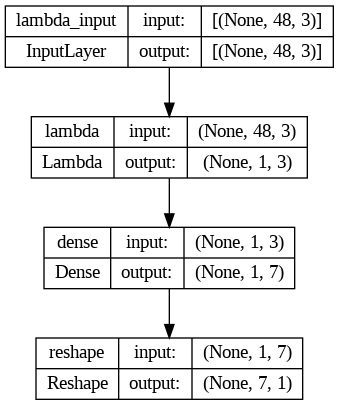


Model evaluation on train dataset:

39/39 [==============================] - 1s 13ms/step - loss: 0.0118 - mae: 0.0807 - mape: 25456.9707 - r2: 0.4102
[0.0118, 0.0807, 25456.9707, 0.4102]

Model evaluation on val dataset:

11/11 [==============================] - 0s 15ms/step - loss: 0.0096 - mae: 0.0711 - mape: 50.5500 - r2: 0.3490
[0.0096, 0.0711, 50.55, 0.349]

Model evaluation on test dataset:

6/6 [==============================] - 0s 15ms/step - loss: 0.0118 - mae: 0.0807 - mape: 54.9702 - r2: 0.3821
[0.0118, 0.0807, 54.9702, 0.3821]

Modeling metrics on train data set:

39/39 [==============================] - 1s 12ms/step
rmse: 0.1084 [0.1084]
mse : 0.0118 [0.0118]
mae : 0.0807 [0.0807]
mape: 11419251507200.0000 [11419251638272.0000]
r2  : 0.4104 [0.4104]

Modeling metrics on validation data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11/11 [==============================] - 0s 12ms/step
rmse: 0.0978 [0.0978]
mse : 0.0096 [0.0096]
mae : 0.0711 [0.0711]
mape: 50.5500 [50.5500]
r2  : 0.3491 [0.3491]

Modeling metrics on test data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6/6 [==============================] - 0s 16ms/step
rmse: 0.1085 [0.1085]
mse : 0.0118 [0.0118]
mae : 0.0807 [0.0807]
mape: 54.9702 [54.9702]
r2  : 0.3823 [0.3823]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


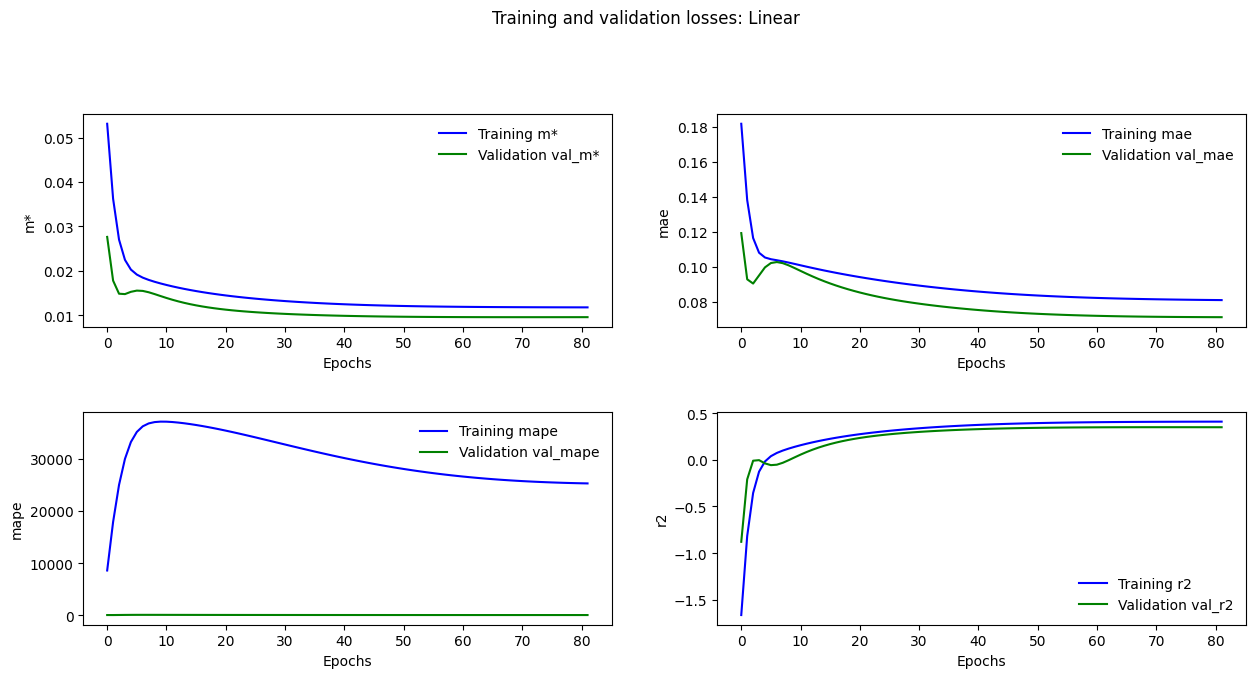

3/3 [==============================] - 0s 7ms/step


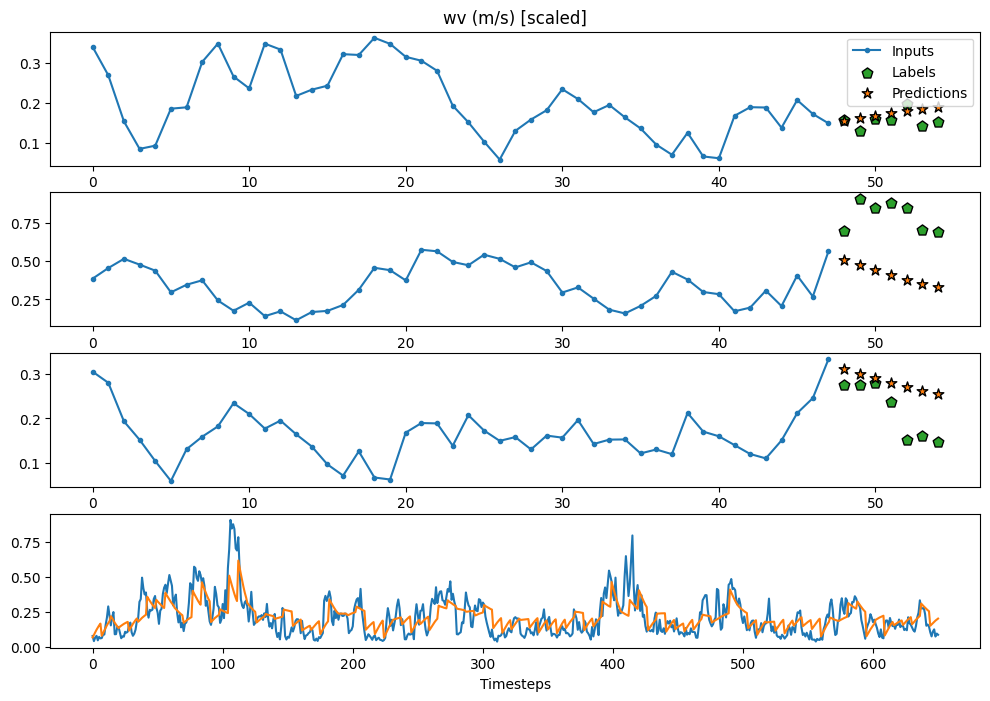

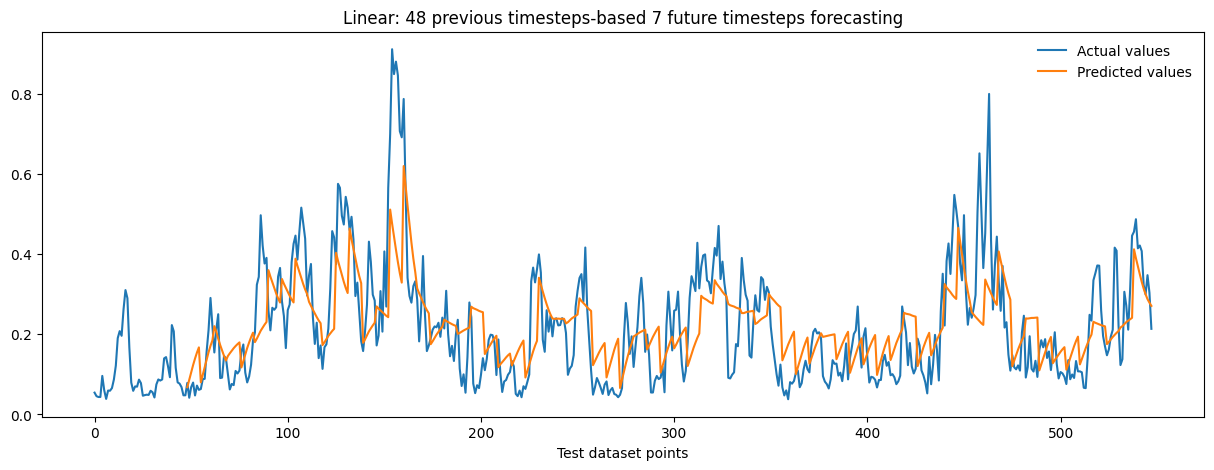

Time taken with the Linear model: 99.47 sec


In [ ]:
dp_linear, mw_linear, mc_linear, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=Linear, title="Linear",
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)


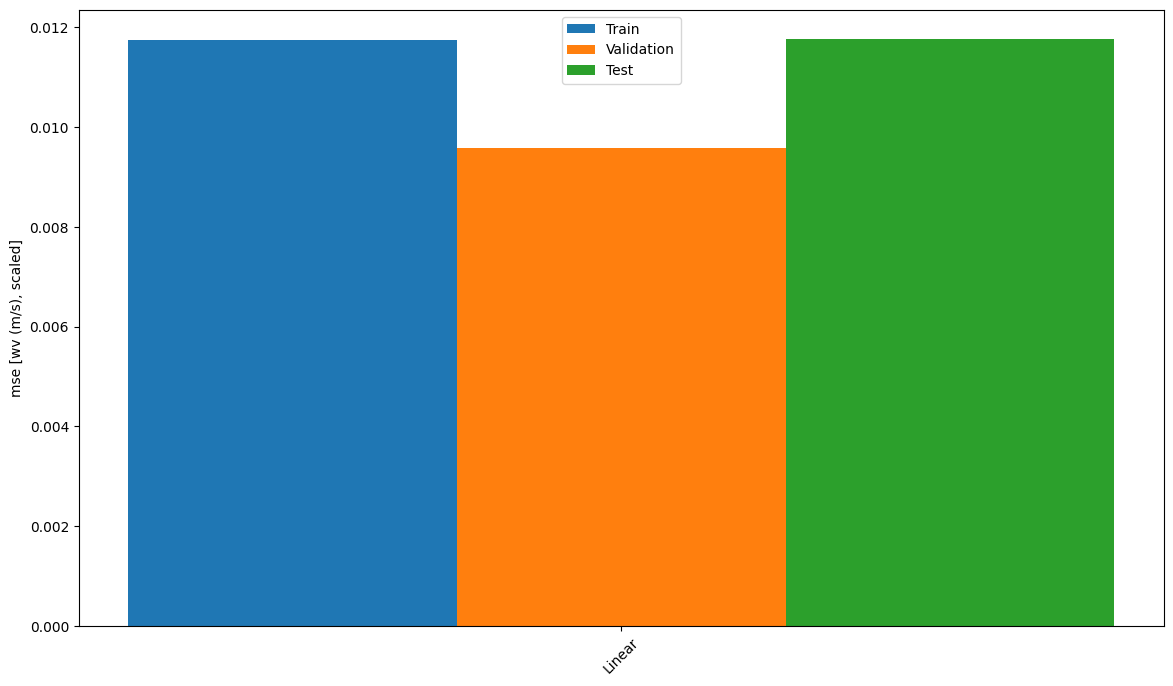

         Train     Val    Test
Linear  0.0118  0.0096  0.0118


In [ ]:
def perfplot(train_performance, val_performance, test_performance, metric_name, anymodel, ylabel):
    # set width of bar
    barWidth = 0.25
    # set height of bar
    metric_index = anymodel.metrics_names.index(metric_name)
    train_metric = [v[metric_index] for v in train_performance.values()]
    val_metric = [v[metric_index] for v in val_performance.values()]
    test_metric = [v[metric_index] for v in test_performance.values()]
    # Set position of bar on X axis
    r1 = np.arange(len(test_performance))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    # Make the plot
    plt.figure(figsize=(14, 8))
    plt.bar(r1, train_metric, width=barWidth, label='Train')
    plt.bar(r2, val_metric, width=barWidth, label='Validation')
    plt.bar(r3, test_metric, width=barWidth, label='Test')
    # Set axis label
    plt.ylabel(ylabel)
    # Add xticks on the middle of the group bars
    plt.xticks([r + barWidth for r in range(len(test_performance))],
               labels=test_performance.keys(), rotation=45)
    plt.legend()
    plt.show()

    print(pd.DataFrame(np.array([train_metric, val_metric, test_metric]),
                       columns=test_performance.keys(),
                       index=["Train", "Val", "Test"]).round(4).transpose())

# Plot performance metrics for the Linear model
perfplot(
    train_performance=train_performance,
    val_performance=val_performance,
    test_performance=test_performance,
    metric_name='loss',
    anymodel=mc_linear.model,
    ylabel='mse [wv (m/s), scaled]'
)

In [ ]:
class CNN(ModelingClass):

    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, conv_width=3):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        self.conv_width = conv_width

    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.Lambda(lambda x: x[:, -self.conv_width:, :]),
            tf.keras.layers.Conv1D(filters=256, kernel_size=self.conv_width, activation='relu'),
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']
Features: ['VPmax (mbar)', 'VPdef (mbar)', 'wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 3)
Label shape (batch size, timesteps, features): (128, 7, 1)

Features used in input: ['VPmax (mbar)', 'VPdef (mbar)']
Target variable: wv (m/s)


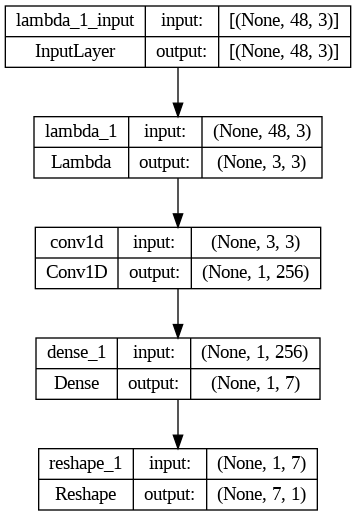


Model evaluation on train dataset:

39/39 [==============================] - 1s 14ms/step - loss: 0.0107 - mae: 0.0772 - mape: 25132.7754 - r2: 0.4613
[0.0107, 0.0772, 25132.7754, 0.4613]

Model evaluation on val dataset:

11/11 [==============================] - 0s 14ms/step - loss: 0.0078 - mae: 0.0645 - mape: 46.6051 - r2: 0.4706
[0.0078, 0.0645, 46.6051, 0.4706]

Model evaluation on test dataset:

6/6 [==============================] - 0s 13ms/step - loss: 0.0122 - mae: 0.0833 - mape: 59.5916 - r2: 0.3569
[0.0122, 0.0833, 59.5916, 0.3569]

Modeling metrics on train data set:

39/39 [==============================] - 1s 13ms/step
rmse: 0.1036 [0.1036]
mse : 0.0107 [0.0107]
mae : 0.0772 [0.0772]
mape: 11268354048000.0000 [11268354211840.0000]
r2  : 0.4614 [0.4614]

Modeling metrics on validation data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11/11 [==============================] - 0s 12ms/step
rmse: 0.0882 [0.0882]
mse : 0.0078 [0.0078]
mae : 0.0645 [0.0645]
mape: 46.6051 [46.6051]
r2  : 0.4707 [0.4707]

Modeling metrics on test data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6/6 [==============================] - 0s 11ms/step
rmse: 0.1107 [0.1107]
mse : 0.0122 [0.0122]
mae : 0.0833 [0.0833]
mape: 59.5916 [59.5916]
r2  : 0.3571 [0.3571]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


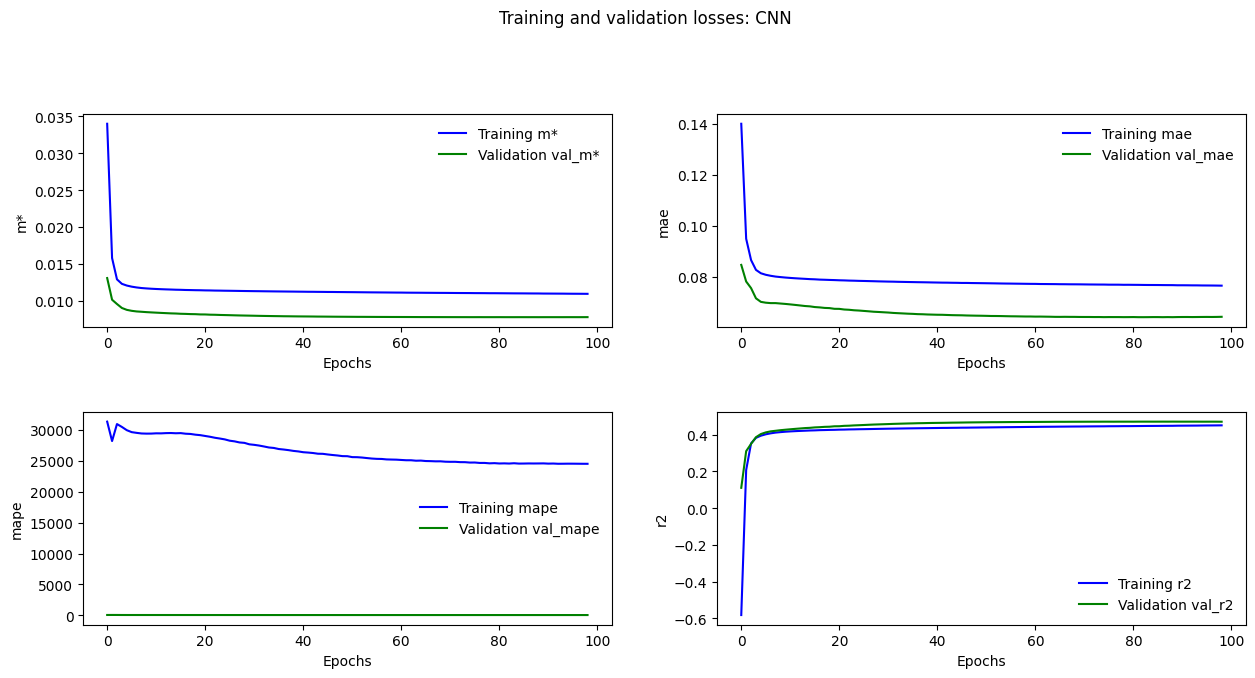

3/3 [==============================] - 0s 6ms/step


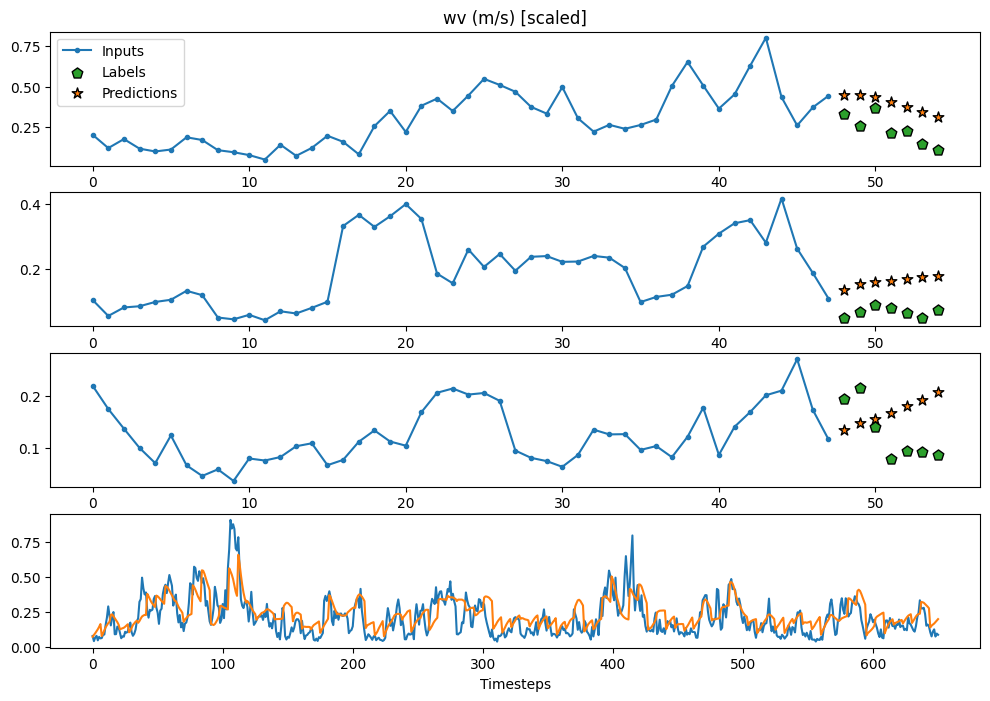

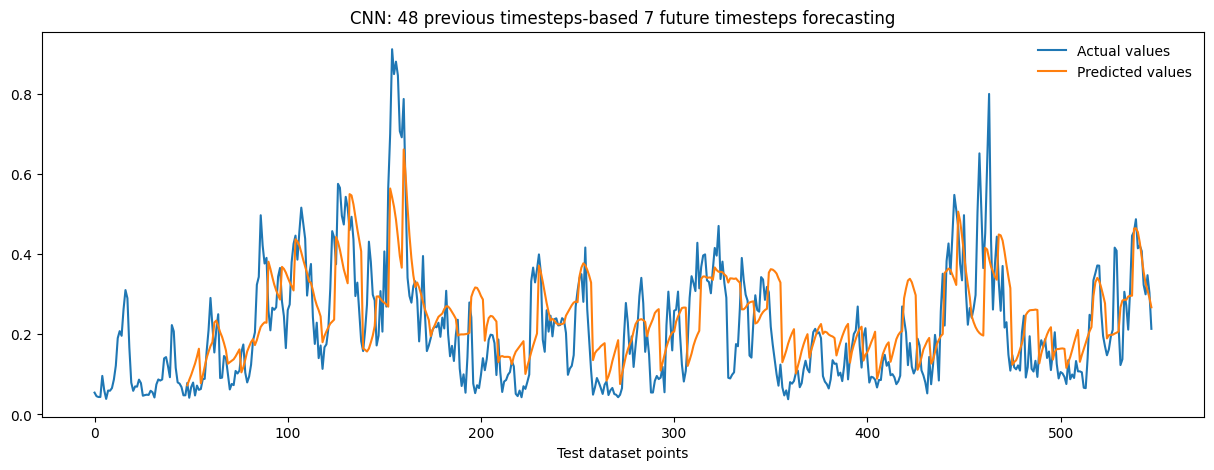

Time taken with the CNN model: 120.04 sec


In [ ]:
dp_cnn, mw_cnn, mc_cnn, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=CNN, title="CNN",
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

In [ ]:
class LSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(32, return_sequences=False),
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']
Features: ['VPmax (mbar)', 'VPdef (mbar)', 'wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 3)
Label shape (batch size, timesteps, features): (128, 7, 1)

Features used in input: ['VPmax (mbar)', 'VPdef (mbar)']
Target variable: wv (m/s)


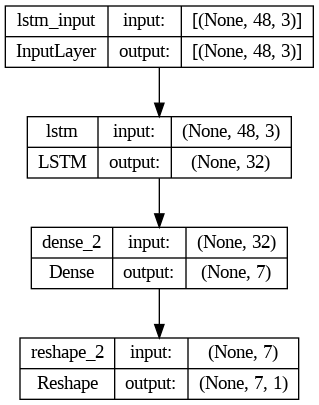


Model evaluation on train dataset:

39/39 [==============================] - 1s 19ms/step - loss: 0.0094 - mae: 0.0705 - mape: 25994.5137 - r2: 0.5300
[0.0094, 0.0705, 25994.5137, 0.53]

Model evaluation on val dataset:

11/11 [==============================] - 0s 20ms/step - loss: 0.0080 - mae: 0.0620 - mape: 38.1542 - r2: 0.4575
[0.008, 0.062, 38.1542, 0.4575]

Model evaluation on test dataset:

6/6 [==============================] - 0s 20ms/step - loss: 0.0118 - mae: 0.0791 - mape: 48.3808 - r2: 0.3778
[0.0118, 0.0791, 48.3808, 0.3778]

Modeling metrics on train data set:

39/39 [==============================] - 1s 17ms/step
rmse: 0.0968 [0.0968]
mse : 0.0094 [0.0094]
mae : 0.0705 [0.0705]
mape: 11660568166400.0000 [11660567773184.0000]
r2  : 0.5301 [0.5301]

Modeling metrics on validation data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11/11 [==============================] - 0s 22ms/step
rmse: 0.0893 [0.0893]
mse : 0.0080 [0.0080]
mae : 0.0620 [0.0620]
mape: 38.1542 [38.1542]
r2  : 0.4576 [0.4576]

Modeling metrics on test data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6/6 [==============================] - 0s 15ms/step
rmse: 0.1089 [0.1089]
mse : 0.0118 [0.0118]
mae : 0.0791 [0.0791]
mape: 48.3808 [48.3808]
r2  : 0.3780 [0.3780]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


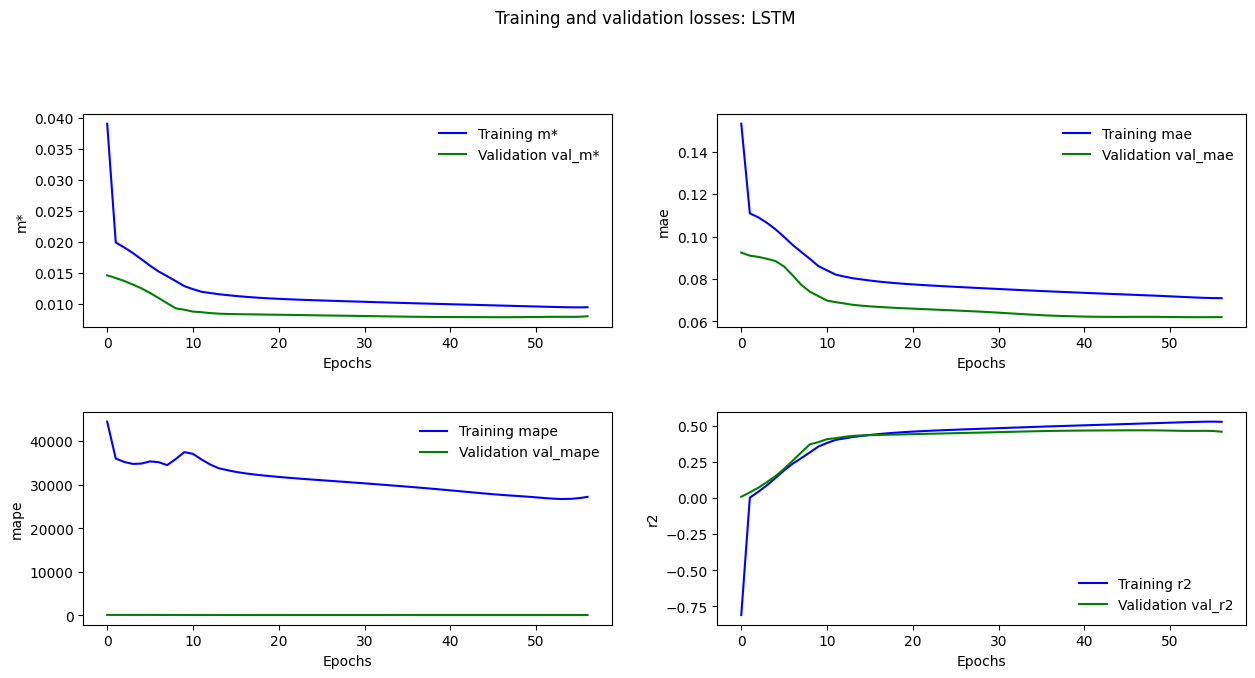

3/3 [==============================] - 0s 12ms/step


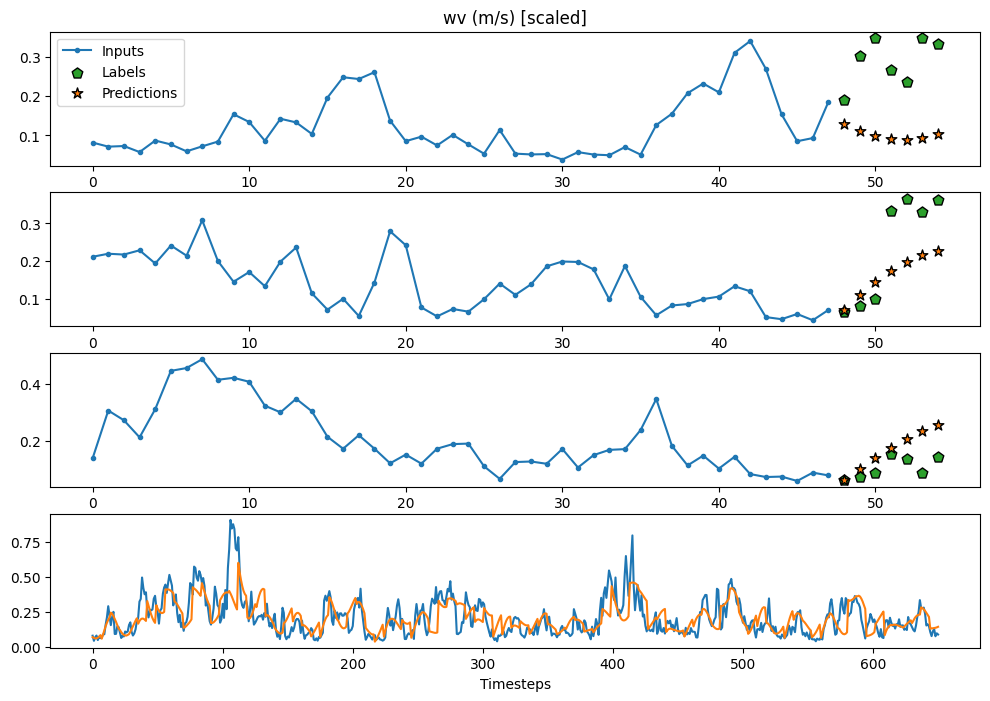

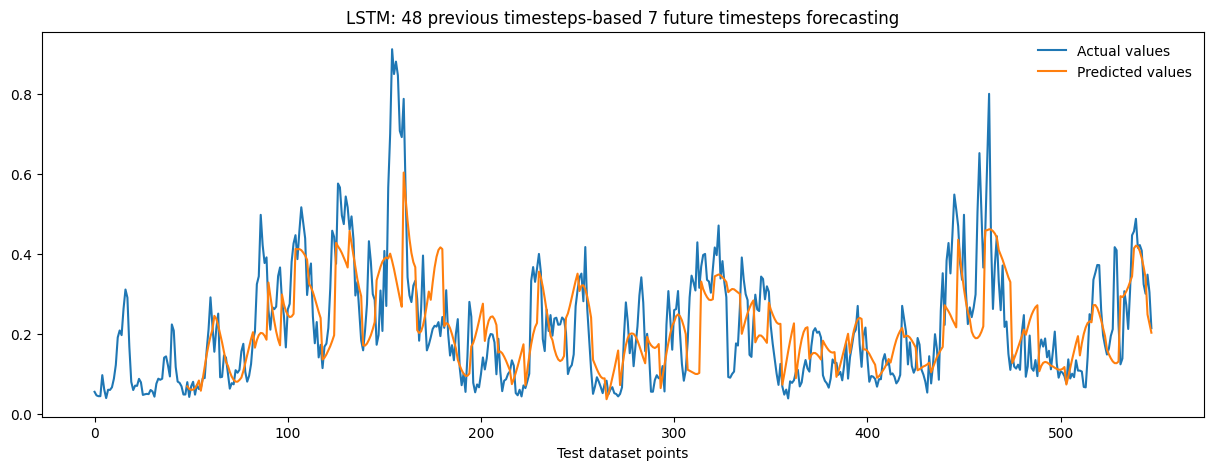

Time taken with the LSTM model: 150.84 sec


In [ ]:
dp_lstm, mw_lstm, mc_lstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=LSTM, title="LSTM",
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

In [ ]:
class StackedGRU(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.GRU(10, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GRU(5),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']
Features: ['VPmax (mbar)', 'VPdef (mbar)', 'wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 3)
Label shape (batch size, timesteps, features): (128, 7, 1)

Features used in input: ['VPmax (mbar)', 'VPdef (mbar)']
Target variable: wv (m/s)


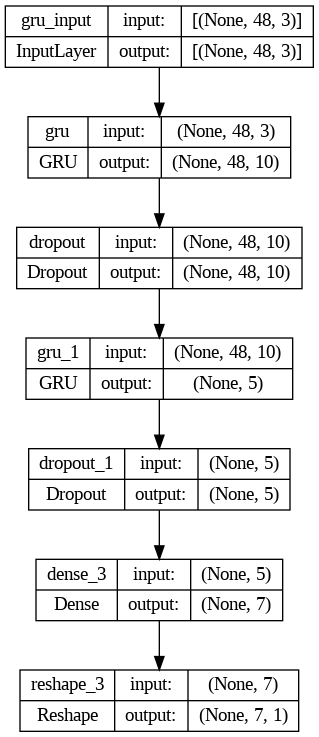


Model evaluation on train dataset:

39/39 [==============================] - 1s 21ms/step - loss: 0.0111 - mae: 0.0782 - mape: 30734.2812 - r2: 0.4415
[0.0111, 0.0782, 30734.2812, 0.4415]

Model evaluation on val dataset:

11/11 [==============================] - 0s 27ms/step - loss: 0.0081 - mae: 0.0661 - mape: 47.1656 - r2: 0.4473
[0.0081, 0.0661, 47.1656, 0.4473]

Model evaluation on test dataset:

6/6 [==============================] - 0s 20ms/step - loss: 0.0117 - mae: 0.0806 - mape: 55.8841 - r2: 0.3857
[0.0117, 0.0806, 55.8841, 0.3857]

Modeling metrics on train data set:

39/39 [==============================] - 2s 19ms/step
rmse: 0.1055 [0.1055]
mse : 0.0111 [0.0111]
mae : 0.0782 [0.0782]
mape: 13789988454400.0000 [13789988651008.0000]
r2  : 0.4416 [0.4416]

Modeling metrics on validation data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11/11 [==============================] - 0s 23ms/step
rmse: 0.0902 [0.0902]
mse : 0.0081 [0.0081]
mae : 0.0661 [0.0661]
mape: 47.1656 [47.1656]
r2  : 0.4474 [0.4474]

Modeling metrics on test data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6/6 [==============================] - 0s 19ms/step
rmse: 0.1082 [0.1082]
mse : 0.0117 [0.0117]
mae : 0.0806 [0.0806]
mape: 55.8841 [55.8841]
r2  : 0.3859 [0.3859]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


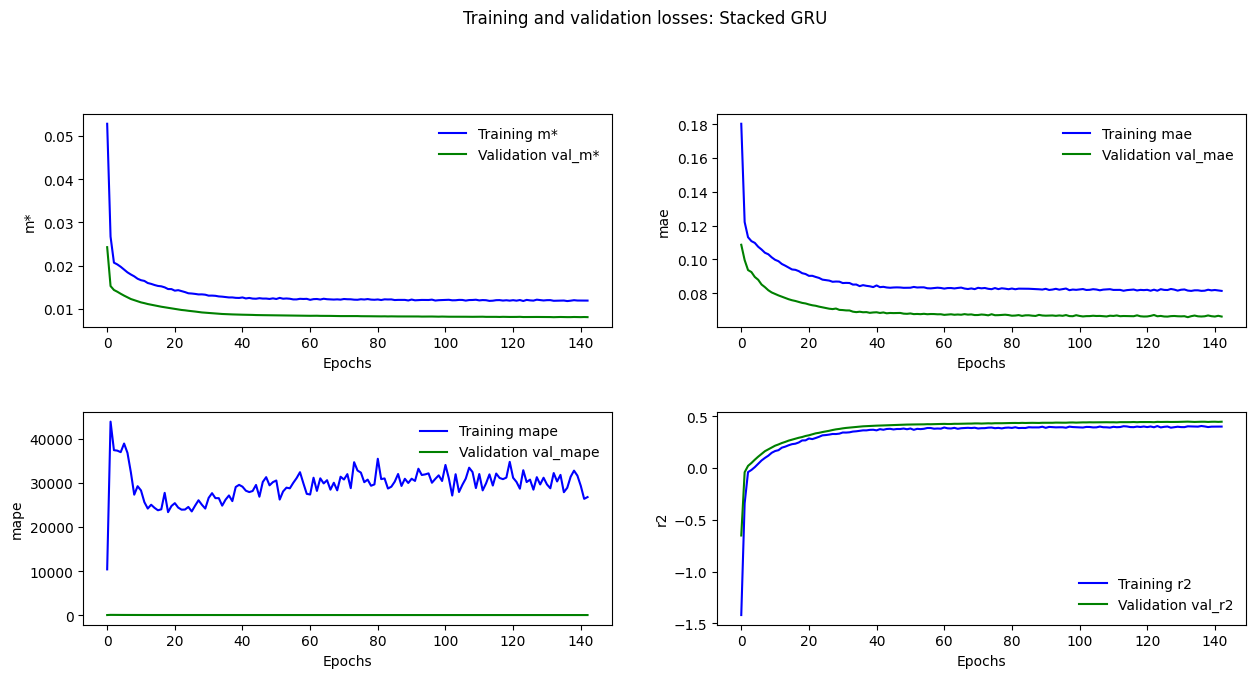

3/3 [==============================] - 0s 18ms/step


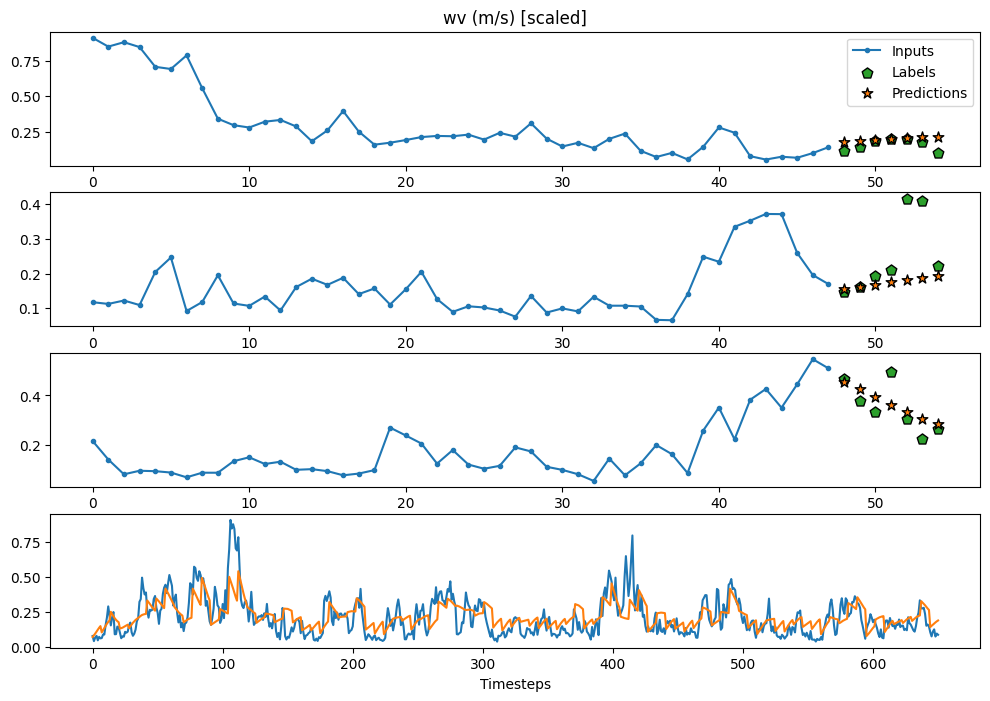

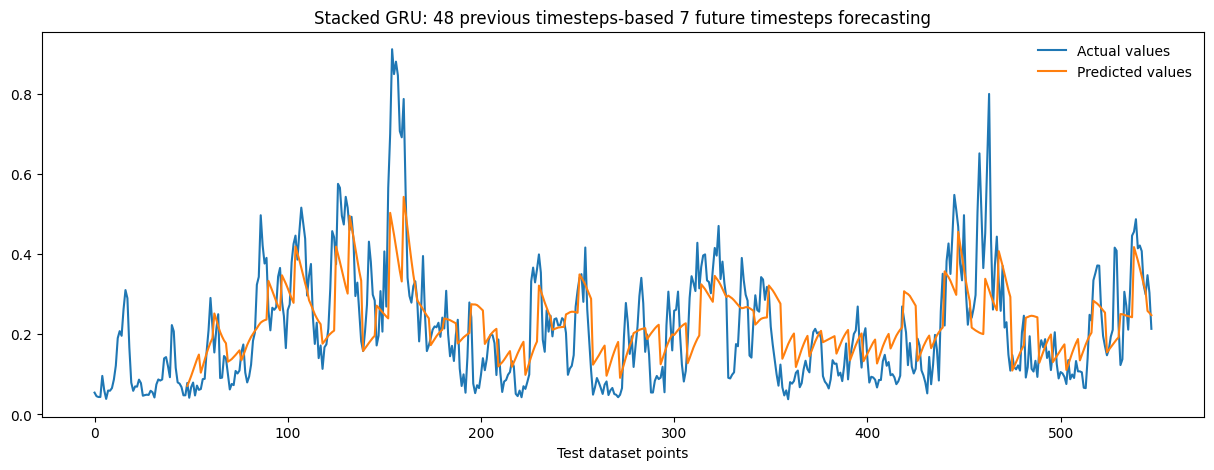

Time taken with the StackedGRU model: 468.61 sec


In [ ]:
dp_sgru, mw_sgru, mc_sgru, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedGRU, title="Stacked GRU",
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

In [ ]:
class EnDeLSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(10, return_sequences=False),
            tf.keras.layers.RepeatVector(self.mapdataset.label_width),
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number, kernel_initializer=tf.initializers.zeros)),
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']
Features: ['VPmax (mbar)', 'VPdef (mbar)', 'wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 3)
Label shape (batch size, timesteps, features): (128, 7, 1)

Features used in input: ['VPmax (mbar)', 'VPdef (mbar)']
Target variable: wv (m/s)


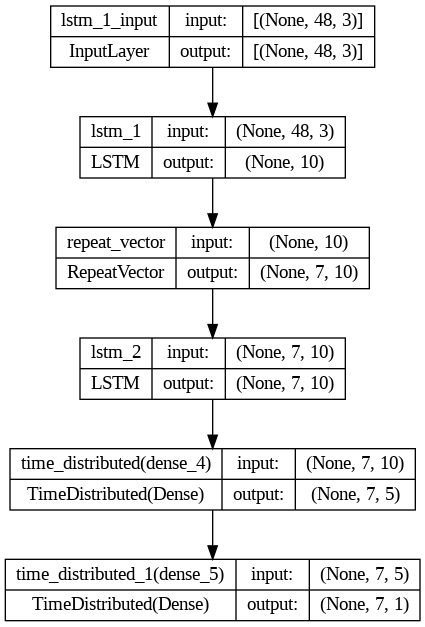


Model evaluation on train dataset:

39/39 [==============================] - 1s 24ms/step - loss: 0.0096 - mae: 0.0698 - mape: 25980.8125 - r2: 0.5189
[0.0096, 0.0698, 25980.8125, 0.5189]

Model evaluation on val dataset:

11/11 [==============================] - 0s 19ms/step - loss: 0.0081 - mae: 0.0629 - mape: 39.6974 - r2: 0.4473
[0.0081, 0.0629, 39.6974, 0.4473]

Model evaluation on test dataset:

6/6 [==============================] - 0s 17ms/step - loss: 0.0112 - mae: 0.0763 - mape: 45.0614 - r2: 0.4110
[0.0112, 0.0763, 45.0614, 0.411]

Modeling metrics on train data set:

39/39 [==============================] - 1s 16ms/step
rmse: 0.0979 [0.0979]
mse : 0.0096 [0.0096]
mae : 0.0698 [0.0698]
mape: 11652334387200.0000 [11652334354432.0000]
r2  : 0.5190 [0.5190]

Modeling metrics on validation data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11/11 [==============================] - 0s 14ms/step
rmse: 0.0902 [0.0902]
mse : 0.0081 [0.0081]
mae : 0.0629 [0.0629]
mape: 39.6974 [39.6974]
r2  : 0.4474 [0.4474]

Modeling metrics on test data set:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6/6 [==============================] - 0s 14ms/step
rmse: 0.1059 [0.1059]
mse : 0.0112 [0.0112]
mae : 0.0763 [0.0763]
mape: 45.0614 [45.0614]
r2  : 0.4112 [0.4112]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


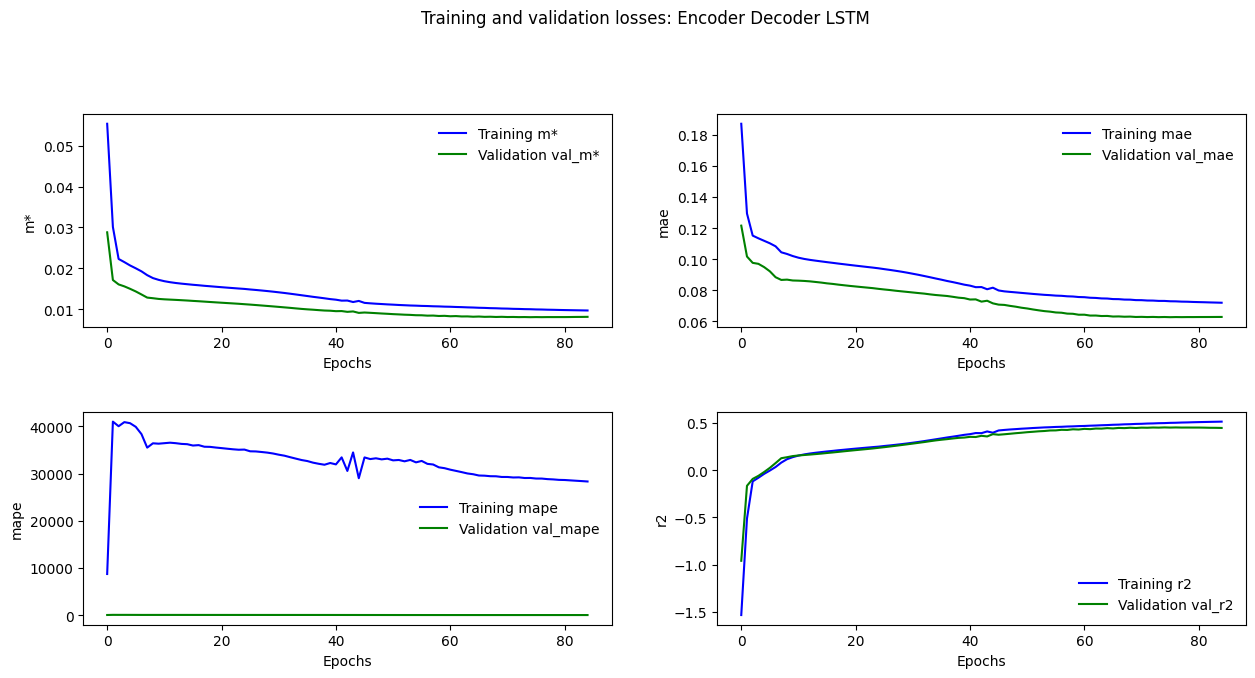

3/3 [==============================] - 0s 10ms/step


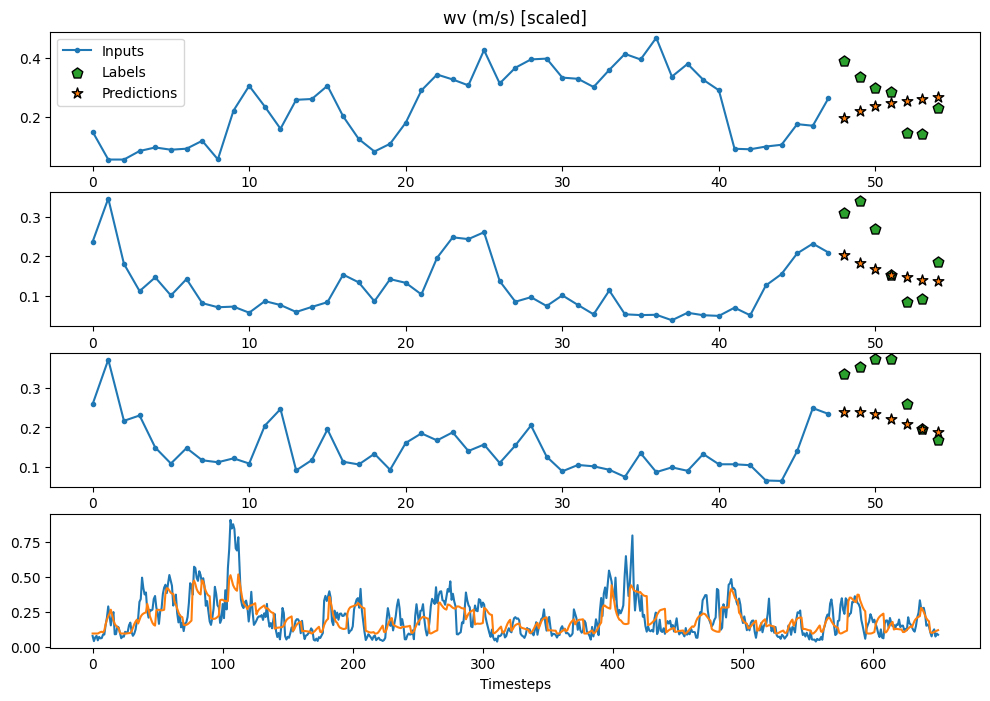

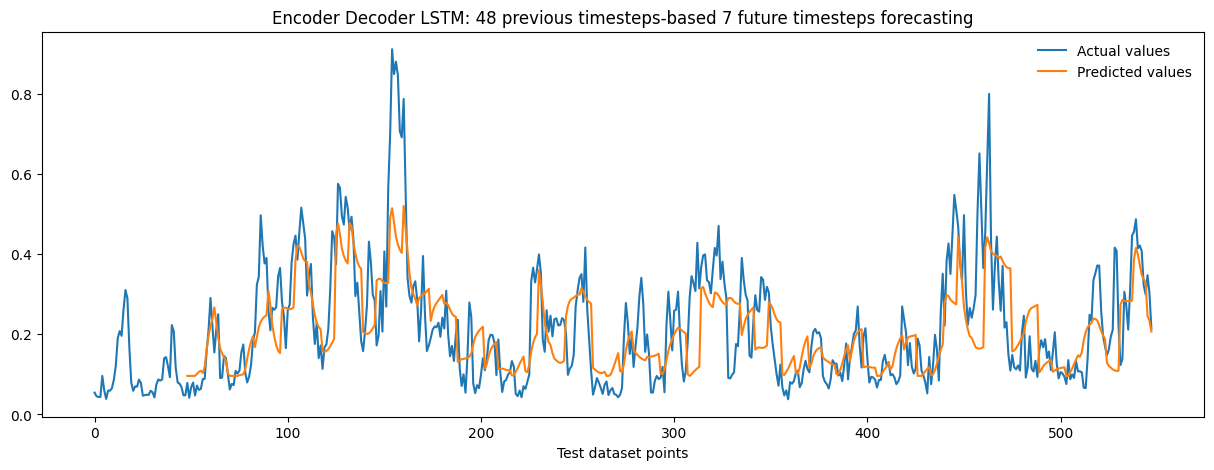

Time taken with the EnDeLSTM model: 198.78 sec


In [ ]:
dp_edlstm, mw_edlstm, mc_edlstm , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=EnDeLSTM, title="Encoder Decoder LSTM",
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

In [ ]:
class StackedLSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(10, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(5),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

In [ ]:
dp_slstm, mw_slstm, mc_slstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedLSTM, title="Stacked LSTM",
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

Using wrap feature selection.
Feature rankings:
VPmax (mbar): Rank 1
VPdef (mbar): Rank 1
VPact (mbar): Rank 2
max. wv (m/s): Rank 3
H2OC (mmol/mol): Rank 4
sh (g/kg): Rank 5
rain (mm): Rank 6
Tpot (K): Rank 7
T (degC): Rank 8
p (mbar): Rank 9
rho (g/m**3): Rank 10
Tlog (degC): Rank 11
Tdew (degC): Rank 12
rh (%): Rank 13
SWDR (W/m²): Rank 14
PAR (µmol/m²/s): Rank 15
max. PAR (µmol/m²/s): Rank 16
raining (s): Rank 17
wd (deg): Rank 18
Selected Features: ['VPmax (mbar)', 'VPdef (mbar)']
Using features: ['VPmax (mbar)', 'VPdef (mbar)']
Columns in train_df after normalization:
['VPmax (mbar)', 'VPdef (mbar)', 'wv (m/s)']

Features used in wrap method: ['VPmax (mbar)', 'VPdef (mbar)']



<ipython-input-15-49e32536dbd9>:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  self.resample_data = self.data.resample(str(self.sampling_window)+'T').mean()


Epoch 1/200
39/39 [==============================] - 12s 121ms/step - loss: 0.0522 - mae: 0.1786 - mape: 13926.6445 - r2: -1.3900 - val_loss: 0.0223 - val_mae: 0.1028 - val_mape: 47.5250 - val_r2: -0.5175
Epoch 2/200
39/39 [==============================] - 4s 92ms/step - loss: 0.0247 - mae: 0.1180 - mape: 43766.6719 - r2: -0.2378 - val_loss: 0.0149 - val_mae: 0.0983 - val_mape: 83.6442 - val_r2: -0.0156
Epoch 3/200
39/39 [==============================] - 2s 53ms/step - loss: 0.0208 - mae: 0.1134 - mape: 38390.5586 - r2: -0.0410 - val_loss: 0.0144 - val_mae: 0.0933 - val_mape: 74.7751 - val_r2: 0.0227
Epoch 4/200
39/39 [==============================] - 2s 56ms/step - loss: 0.0203 - mae: 0.1111 - mape: 35486.4531 - r2: -0.0188 - val_loss: 0.0141 - val_mae: 0.0918 - val_mape: 72.8853 - val_r2: 0.0427
Epoch 5/200
39/39 [==============================] - 2s 57ms/step - loss: 0.0200 - mae: 0.1100 - mape: 37057.6523 - r2: -0.0029 - val_loss: 0.0137 - val_mae: 0.0894 - val_mape: 68.9510 - v

In [ ]:
def perfplot(train_performance, val_performance, test_performance, metric_name, anymodel, ylabel):
    # set width of bar
    barWidth = 0.25
    # set height of bar
    metric_index = anymodel.metrics_names.index(metric_name)
    train_metric = [v[metric_index] for v in train_performance.values()]
    val_metric = [v[metric_index] for v in val_performance.values()]
    test_metric = [v[metric_index] for v in test_performance.values()]
    # Set position of bar on X axis
    r1 = np.arange(len(test_performance))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    # Make the plot
    plt.figure(figsize=(14, 8))
    plt.bar(r1, train_metric, width=barWidth, label='Train')
    plt.bar(r2, val_metric, width=barWidth, label='Validation')
    plt.bar(r3, test_metric, width=barWidth, label='Test')
    # Set axis label
    plt.ylabel(ylabel)
    plt.xticks([r + barWidth for r in range(len(test_performance))],
               labels=test_performance.keys(), rotation=45)
    plt.legend()
    plt.show()

    print(pd.DataFrame(np.array([train_metric, val_metric, test_metric]),
                 columns=test_performance.keys(),
                 index=["Train", "Val", "Test"]).round(4).transpose())

In [ ]:
perfplot(train_performance, val_performance, test_performance, metric_name='loss', anymodel=mc_edlstm.model, ylabel='mse [wv (m/s), scaled]')


In [ ]:
# Assuming dp_lstm, mw_lstm, mc_lstm are already defined from the previous code

# Number of input and output time steps
n_input = mw_lstm.input_width
n_output = mw_lstm.label_width
sampling_window = dp_lstm.sampling_window  # Should be 60 as per your initial setup

# Get the last n_input time steps from the resampled data
input_data = dp_lstm.resample_data[-n_input:]

# Scale the input data using the same scaler
input_data_scaled = pd.DataFrame(
    dp_lstm.scaler.transform(input_data),
    columns=input_data.columns,
    index=input_data.index
)

# Create input array for the model (shape: [batch_size, n_input, num_features])
input_array = input_data_scaled.values.reshape((1, n_input, -1))

# Make predictions (shape: [batch_size, n_output, label_feature_number])
predictions_scaled = mc_lstm.model.predict(input_array)

# Find the index of the target variable in the columns
wv_col_index = input_data_scaled.columns.get_loc(dp_lstm.target_column)

# Get the last row of input_data_scaled to fill in other features
last_row_scaled = input_data_scaled.iloc[-1].values  # shape: (num_features,)

# Create full_predictions_scaled array
full_predictions_scaled = np.tile(last_row_scaled, (n_output, 1))  # shape: (n_output, num_features)

# Set the predicted values for 'wv (m/s)'
full_predictions_scaled[:, wv_col_index] = predictions_scaled[0, :, 0]

# Inverse transform to get back to original scale
full_predictions = dp_lstm.scaler.inverse_transform(full_predictions_scaled)

# Extract the predicted wind speeds
predicted_wv = full_predictions[:, wv_col_index]

# Generate future dates starting after the last date in the input data
last_date = input_data.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(minutes=sampling_window),
    periods=n_output,
    freq=f'{sampling_window}T'
)

# Create DataFrame with predictions
predicted_df = pd.DataFrame({
    'Date Time': future_dates,
    'Predicted wv (m/s)': predicted_wv
})

# Display the predicted wind speeds
print(predicted_df)


In [ ]:
# Number of input and output time steps
n_input = mw_lstm.input_width
n_output = mw_lstm.label_width
sampling_window = dp_lstm.sampling_window  # Should be 60 as per your initial setup

# Get the last n_input time steps from the resampled data
input_data = dp_lstm.resample_data[-n_input:]

# Scale the input data using the same scaler
input_data_scaled = pd.DataFrame(
    dp_lstm.scaler.transform(input_data),
    columns=input_data.columns,
    index=input_data.index
)

# Create input array for the model (shape: [batch_size, n_input, num_features])
input_array = input_data_scaled.values.reshape((1, n_input, -1))

# Make predictions (shape: [batch_size, n_output, label_feature_number])
predictions_scaled = mc_lstm.model.predict(input_array)

# Find the index of the target variable in the columns
wv_col_index = input_data_scaled.columns.get_loc(dp_lstm.target_column)

# Get the last row of input_data_scaled to fill in other features
last_row_scaled = input_data_scaled.iloc[-1].values  # shape: (num_features,)

# Create full_predictions_scaled array
full_predictions_scaled = np.tile(last_row_scaled, (n_output, 1))  # shape: (n_output, num_features)

# Set the predicted values for 'wv (m/s)'
full_predictions_scaled[:, wv_col_index] = predictions_scaled[0, :, 0]

# Inverse transform to get back to original scale
full_predictions = dp_lstm.scaler.inverse_transform(full_predictions_scaled)

# Extract the predicted wind speeds
predicted_wv = full_predictions[:, wv_col_index]

# Generate future dates starting from the present date and time
current_datetime = pd.Timestamp.now()
future_dates = pd.date_range(
    start=current_datetime,
    periods=n_output,
    freq=f'{sampling_window}T'
)

# Create DataFrame with predictions
predicted_df = pd.DataFrame({
    'Date Time': future_dates,
    'Predicted wv (m/s)': predicted_wv
})

# Display the predicted wind speeds
print(predicted_df)
